Практика 8
===

Задание 1

In [4]:
from sklearn import datasets

iris = datasets.load_iris()

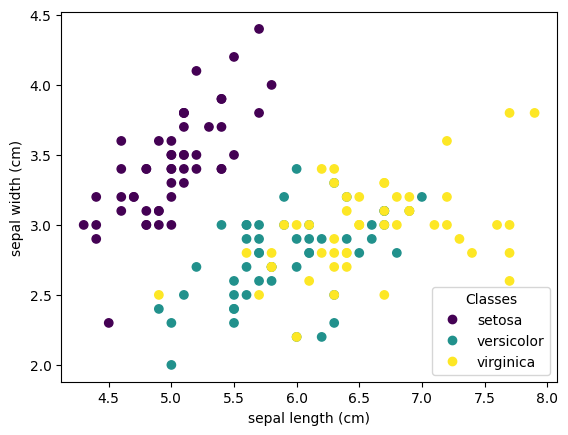

In [5]:
import matplotlib.pyplot as plt

_, ax = plt.subplots()
scatter = ax.scatter(iris.data[:, 0], iris.data[:, 1], c=iris.target)
ax.set(xlabel=iris.feature_names[0], ylabel=iris.feature_names[1])
_ = ax.legend(
    scatter.legend_elements()[0], iris.target_names, loc="lower right", title="Classes"
)

Задание 2

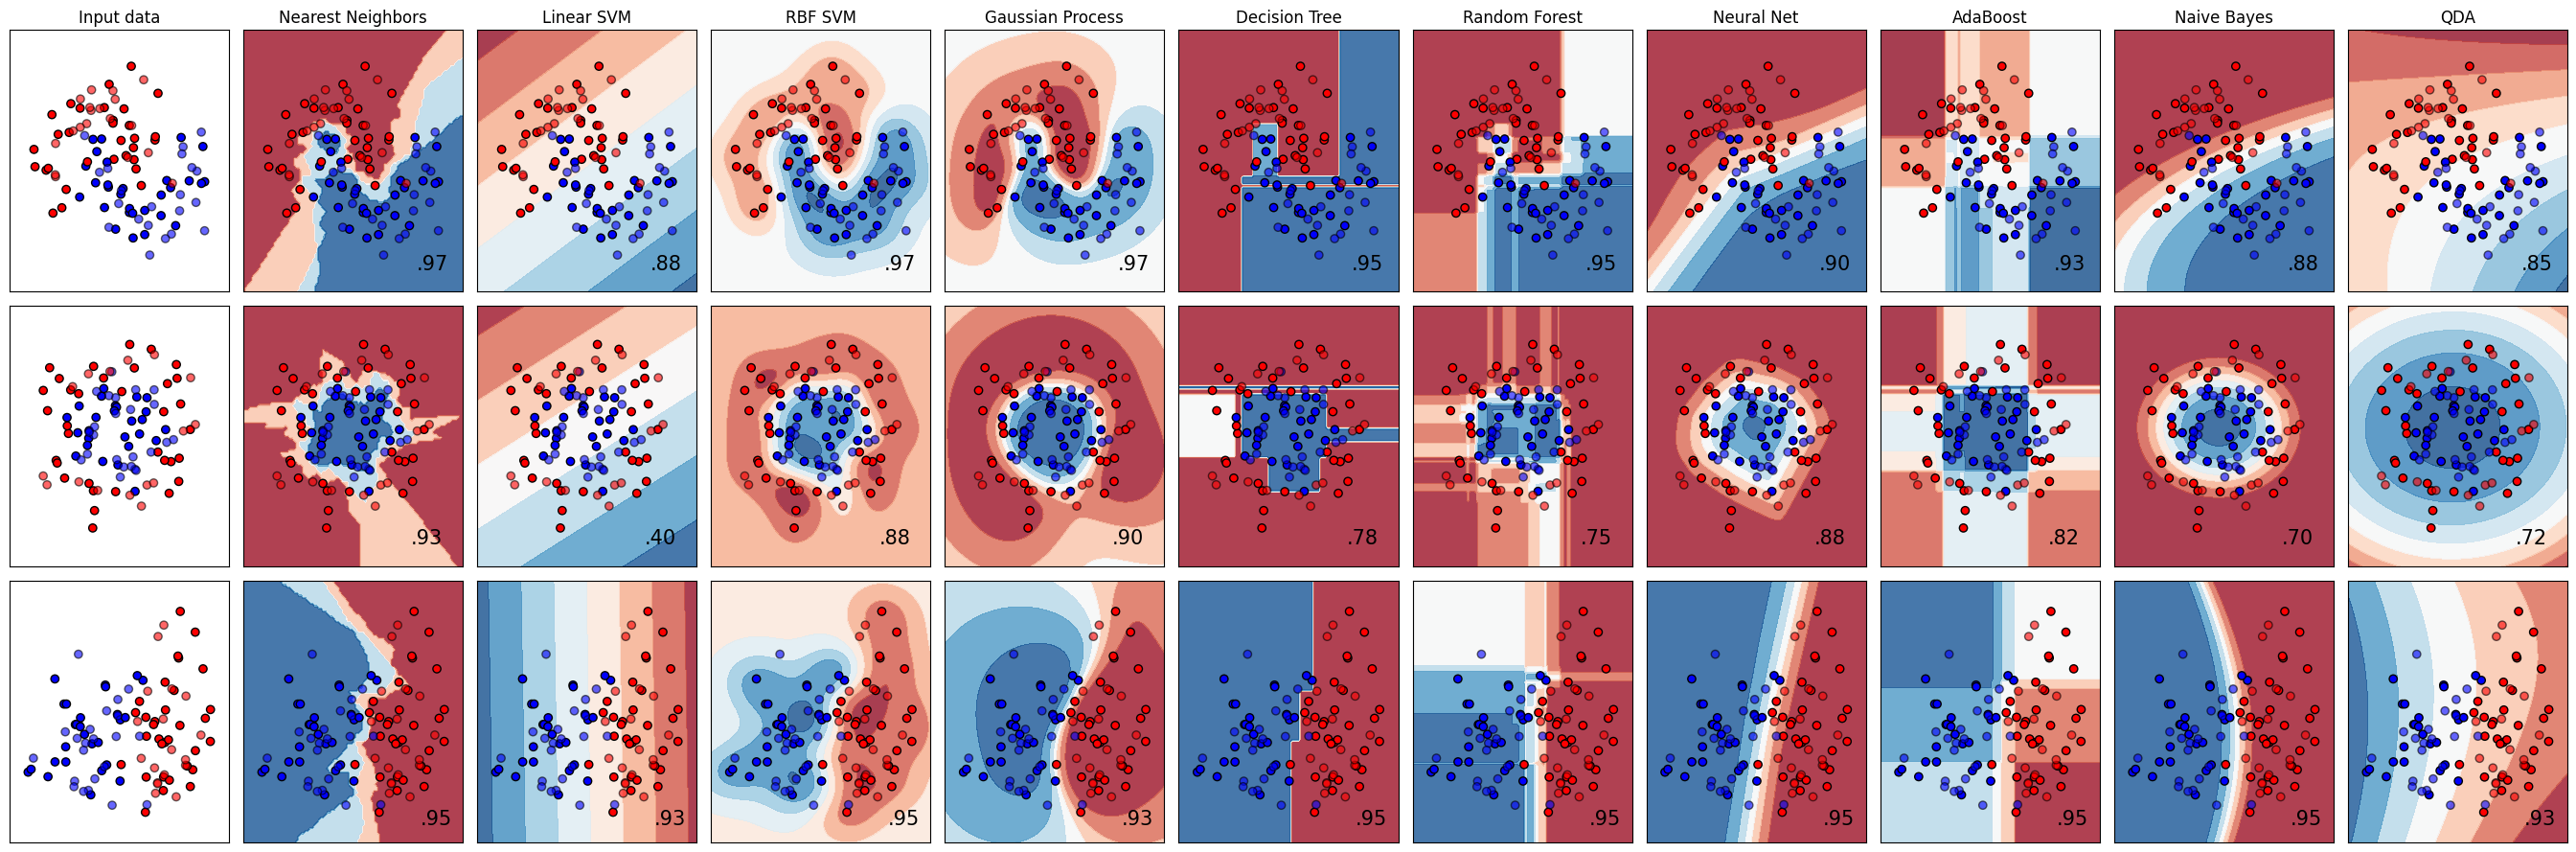

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

from sklearn.datasets import make_circles, make_classification, make_moons
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025, random_state=42),
    SVC(gamma=2, C=1, random_state=42),
    GaussianProcessClassifier(1.0 * RBF(1.0), random_state=42),
    DecisionTreeClassifier(max_depth=5, random_state=42),
    RandomForestClassifier(
        max_depth=5, n_estimators=10, max_features=1, random_state=42
    ),
    MLPClassifier(alpha=1, max_iter=1000, random_state=42),
    AdaBoostClassifier(random_state=42),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
]

X, y = make_classification(
    n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=1
)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [
    make_moons(noise=0.3, random_state=0),
    make_circles(noise=0.2, factor=0.5, random_state=1),
    linearly_separable,
]

figure = plt.figure(figsize=(27, 9))
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, random_state=42
    )

    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(["#FF0000", "#0000FF"])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
    # Plot the testing points
    ax.scatter(
        X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k"
    )
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)

        clf = make_pipeline(StandardScaler(), clf)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        DecisionBoundaryDisplay.from_estimator(
            clf, X, cmap=cm, alpha=0.8, ax=ax, eps=0.5
        )

        # Plot the training points
        ax.scatter(
            X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k"
        )
        # Plot the testing points
        ax.scatter(
            X_test[:, 0],
            X_test[:, 1],
            c=y_test,
            cmap=cm_bright,
            edgecolors="k",
            alpha=0.6,
        )

        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(
            x_max - 0.3,
            y_min + 0.3,
            ("%.2f" % score).lstrip("0"),
            size=15,
            horizontalalignment="right",
        )
        i += 1

plt.tight_layout()
plt.show()

Алгоритмы кластеризации

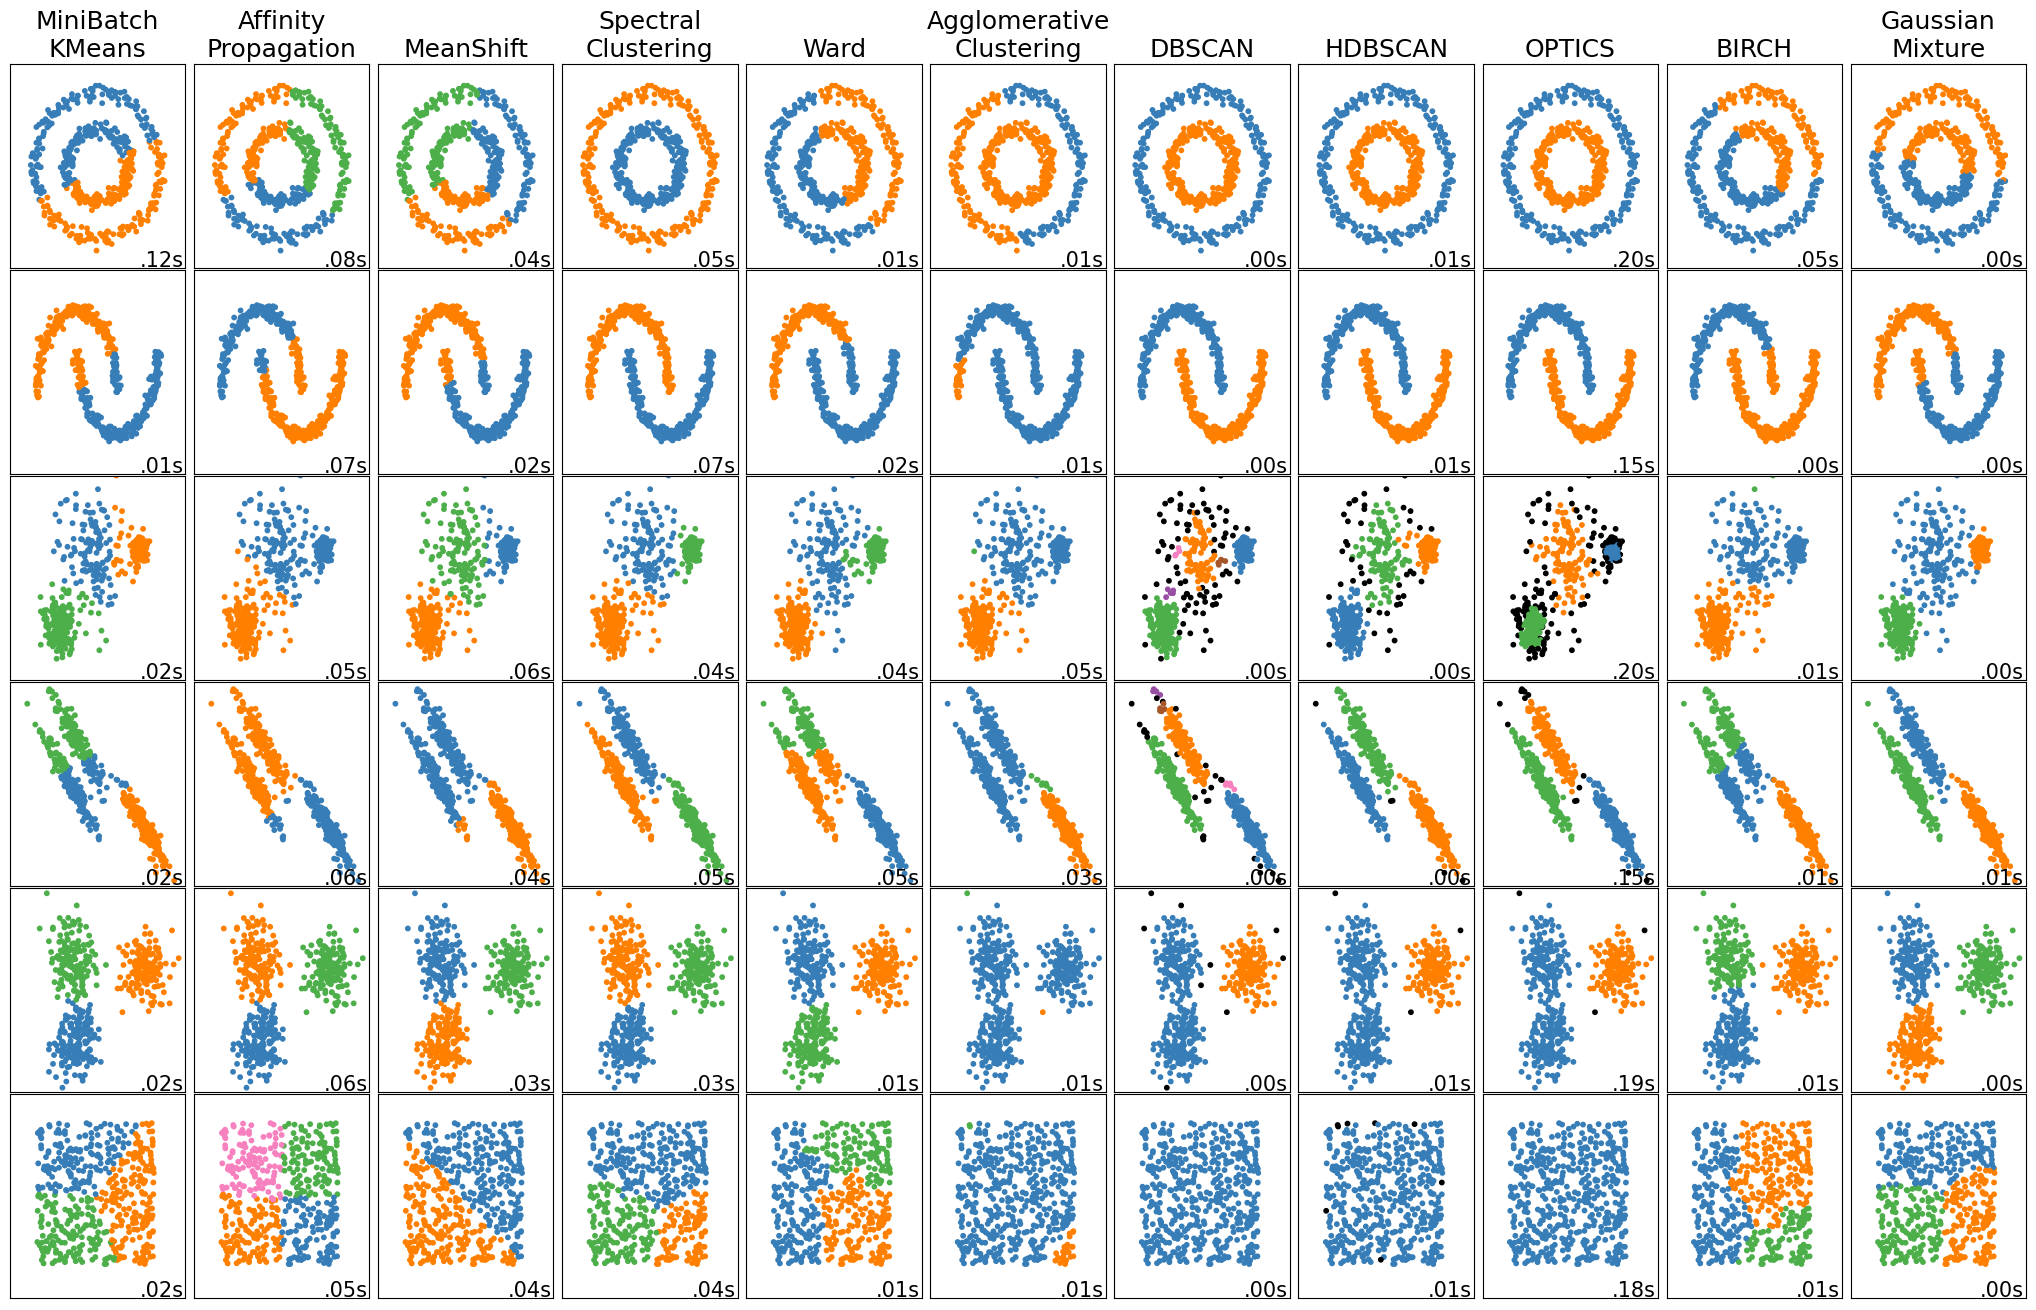

In [7]:
import time
import warnings
from itertools import cycle, islice

import matplotlib.pyplot as plt
import numpy as np

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 500
seed = 30
noisy_circles = datasets.make_circles(
    n_samples=n_samples, factor=0.5, noise=0.05, random_state=seed
)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05, random_state=seed)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=seed)
rng = np.random.RandomState(seed)
no_structure = rng.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state
)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(9 * 2 + 3, 13))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.95, wspace=0.05, hspace=0.01
)

plot_num = 1

default_base = {
    "quantile": 0.3,
    "eps": 0.3,
    "damping": 0.9,
    "preference": -200,
    "n_neighbors": 3,
    "n_clusters": 3,
    "min_samples": 7,
    "xi": 0.05,
    "min_cluster_size": 0.1,
    "allow_single_cluster": True,
    "hdbscan_min_cluster_size": 15,
    "hdbscan_min_samples": 3,
    "random_state": 42,
}

datasets = [
    (
        noisy_circles,
        {
            "damping": 0.77,
            "preference": -240,
            "quantile": 0.2,
            "n_clusters": 2,
            "min_samples": 7,
            "xi": 0.08,
        },
    ),
    (
        noisy_moons,
        {
            "damping": 0.75,
            "preference": -220,
            "n_clusters": 2,
            "min_samples": 7,
            "xi": 0.1,
        },
    ),
    (
        varied,
        {
            "eps": 0.18,
            "n_neighbors": 2,
            "min_samples": 7,
            "xi": 0.01,
            "min_cluster_size": 0.2,
        },
    ),
    (
        aniso,
        {
            "eps": 0.15,
            "n_neighbors": 2,
            "min_samples": 7,
            "xi": 0.1,
            "min_cluster_size": 0.2,
        },
    ),
    (blobs, {"min_samples": 7, "xi": 0.1, "min_cluster_size": 0.2}),
    (no_structure, {}),
]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params["quantile"])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params["n_neighbors"], include_self=False
    )
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(
        n_clusters=params["n_clusters"],
        n_init="auto",
        random_state=params["random_state"],
    )
    ward = cluster.AgglomerativeClustering(
        n_clusters=params["n_clusters"], linkage="ward", connectivity=connectivity
    )
    spectral = cluster.SpectralClustering(
        n_clusters=params["n_clusters"],
        eigen_solver="arpack",
        affinity="nearest_neighbors",
        random_state=params["random_state"],
    )
    dbscan = cluster.DBSCAN(eps=params["eps"])
    hdbscan = cluster.HDBSCAN(
        min_samples=params["hdbscan_min_samples"],
        min_cluster_size=params["hdbscan_min_cluster_size"],
        allow_single_cluster=params["allow_single_cluster"],
    )
    optics = cluster.OPTICS(
        min_samples=params["min_samples"],
        xi=params["xi"],
        min_cluster_size=params["min_cluster_size"],
    )
    affinity_propagation = cluster.AffinityPropagation(
        damping=params["damping"],
        preference=params["preference"],
        random_state=params["random_state"],
    )
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average",
        metric="cityblock",
        n_clusters=params["n_clusters"],
        connectivity=connectivity,
    )
    birch = cluster.Birch(n_clusters=params["n_clusters"])
    gmm = mixture.GaussianMixture(
        n_components=params["n_clusters"],
        covariance_type="full",
        random_state=params["random_state"],
    )

    clustering_algorithms = (
        ("MiniBatch\nKMeans", two_means),
        ("Affinity\nPropagation", affinity_propagation),
        ("MeanShift", ms),
        ("Spectral\nClustering", spectral),
        ("Ward", ward),
        ("Agglomerative\nClustering", average_linkage),
        ("DBSCAN", dbscan),
        ("HDBSCAN", hdbscan),
        ("OPTICS", optics),
        ("BIRCH", birch),
        ("Gaussian\nMixture", gmm),
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the "
                + "connectivity matrix is [0-9]{1,2}"
                + " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning,
            )
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding"
                + " may not work as expected.",
                category=UserWarning,
            )
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, "labels_"):
            y_pred = algorithm.labels_.astype(int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(
            list(
                islice(
                    cycle(
                        [
                            "#377eb8",
                            "#ff7f00",
                            "#4daf4a",
                            "#f781bf",
                            "#a65628",
                            "#984ea3",
                            "#999999",
                            "#e41a1c",
                            "#dede00",
                        ]
                    ),
                    int(max(y_pred) + 1),
                )
            )
        )
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(
            0.99,
            0.01,
            ("%.2fs" % (t1 - t0)).lstrip("0"),
            transform=plt.gca().transAxes,
            size=15,
            horizontalalignment="right",
        )
        plot_num += 1

plt.show()

Задание 3 (k-ближайших соседей)

c:\Users\galileg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


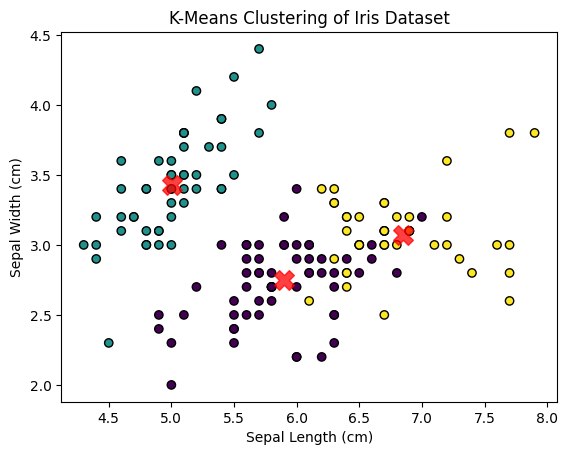

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import datasets

# Загрузим данные
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Используем k-средних для кластеризации
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X)

# Получим метки кластеров
labels = kmeans.labels_

# Визуализируем результат
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', edgecolors='k')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', marker='X', s=200, alpha=0.75)
plt.xlabel('Sepal Length (cm)')
plt.ylabel('Sepal Width (cm)')
plt.title('K-Means Clustering of Iris Dataset')
plt.show()


Задание 4 (Случайный лес)

DecisionTree with features [0, 1] has a score of 0.9266666666666666
RandomForest with 30 estimators with features [0, 1] has a score of 0.9266666666666666
ExtraTrees with 30 estimators with features [0, 1] has a score of 0.9266666666666666
AdaBoost with 30 estimators with features [0, 1] has a score of 0.8666666666666667
DecisionTree with features [0, 2] has a score of 0.9933333333333333
RandomForest with 30 estimators with features [0, 2] has a score of 0.9933333333333333
ExtraTrees with 30 estimators with features [0, 2] has a score of 0.9933333333333333
AdaBoost with 30 estimators with features [0, 2] has a score of 0.9933333333333333
DecisionTree with features [2, 3] has a score of 0.9933333333333333
RandomForest with 30 estimators with features [2, 3] has a score of 0.9933333333333333
ExtraTrees with 30 estimators with features [2, 3] has a score of 0.9933333333333333
AdaBoost with 30 estimators with features [2, 3] has a score of 0.9933333333333333


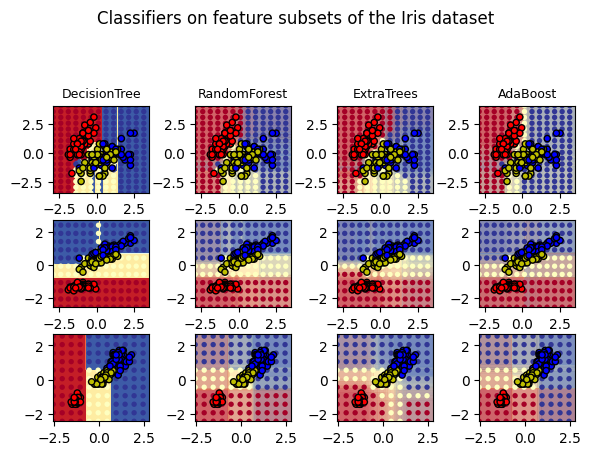

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

from sklearn.datasets import load_iris
from sklearn.ensemble import (
    AdaBoostClassifier,
    ExtraTreesClassifier,
    RandomForestClassifier,
)
from sklearn.tree import DecisionTreeClassifier

# Parameters
n_classes = 3
n_estimators = 30
cmap = plt.cm.RdYlBu
plot_step = 0.02  # fine step width for decision surface contours
plot_step_coarser = 0.5  # step widths for coarse classifier guesses
RANDOM_SEED = 13  # fix the seed on each iteration

# Load data
iris = load_iris()

plot_idx = 1

models = [
    DecisionTreeClassifier(max_depth=None),
    RandomForestClassifier(n_estimators=n_estimators),
    ExtraTreesClassifier(n_estimators=n_estimators),
    AdaBoostClassifier(DecisionTreeClassifier(max_depth=3), n_estimators=n_estimators),
]

for pair in ([0, 1], [0, 2], [2, 3]):
    for model in models:
        # We only take the two corresponding features
        X = iris.data[:, pair]
        y = iris.target

        # Shuffle
        idx = np.arange(X.shape[0])
        np.random.seed(RANDOM_SEED)
        np.random.shuffle(idx)
        X = X[idx]
        y = y[idx]

        # Standardize
        mean = X.mean(axis=0)
        std = X.std(axis=0)
        X = (X - mean) / std

        # Train
        model.fit(X, y)

        scores = model.score(X, y)
        # Create a title for each column and the console by using str() and
        # slicing away useless parts of the string
        model_title = str(type(model)).split(".")[-1][:-2][: -len("Classifier")]

        model_details = model_title
        if hasattr(model, "estimators_"):
            model_details += " with {} estimators".format(len(model.estimators_))
        print(model_details + " with features", pair, "has a score of", scores)

        plt.subplot(3, 4, plot_idx)
        if plot_idx <= len(models):
            # Add a title at the top of each column
            plt.title(model_title, fontsize=9)

        # Now plot the decision boundary using a fine mesh as input to a
        # filled contour plot
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(
            np.arange(x_min, x_max, plot_step), np.arange(y_min, y_max, plot_step)
        )

        # Plot either a single DecisionTreeClassifier or alpha blend the
        # decision surfaces of the ensemble of classifiers
        if isinstance(model, DecisionTreeClassifier):
            Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            cs = plt.contourf(xx, yy, Z, cmap=cmap)
        else:
            # Choose alpha blend level with respect to the number
            # of estimators
            # that are in use (noting that AdaBoost can use fewer estimators
            # than its maximum if it achieves a good enough fit early on)
            estimator_alpha = 1.0 / len(model.estimators_)
            for tree in model.estimators_:
                Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])
                Z = Z.reshape(xx.shape)
                cs = plt.contourf(xx, yy, Z, alpha=estimator_alpha, cmap=cmap)

        # Build a coarser grid to plot a set of ensemble classifications
        # to show how these are different to what we see in the decision
        # surfaces. These points are regularly space and do not have a
        # black outline
        xx_coarser, yy_coarser = np.meshgrid(
            np.arange(x_min, x_max, plot_step_coarser),
            np.arange(y_min, y_max, plot_step_coarser),
        )
        Z_points_coarser = model.predict(
            np.c_[xx_coarser.ravel(), yy_coarser.ravel()]
        ).reshape(xx_coarser.shape)
        cs_points = plt.scatter(
            xx_coarser,
            yy_coarser,
            s=15,
            c=Z_points_coarser,
            cmap=cmap,
            edgecolors="none",
        )

        # Plot the training points, these are clustered together and have a
        # black outline
        plt.scatter(
            X[:, 0],
            X[:, 1],
            c=y,
            cmap=ListedColormap(["r", "y", "b"]),
            edgecolor="k",
            s=20,
        )
        plot_idx += 1  # move on to the next plot in sequence

plt.suptitle("Classifiers on feature subsets of the Iris dataset", fontsize=12)
plt.axis("tight")
plt.tight_layout(h_pad=0.2, w_pad=0.2, pad=2.5)
plt.show()

Задание 5 (Классификация набора машинами опорных векторов/SVM)

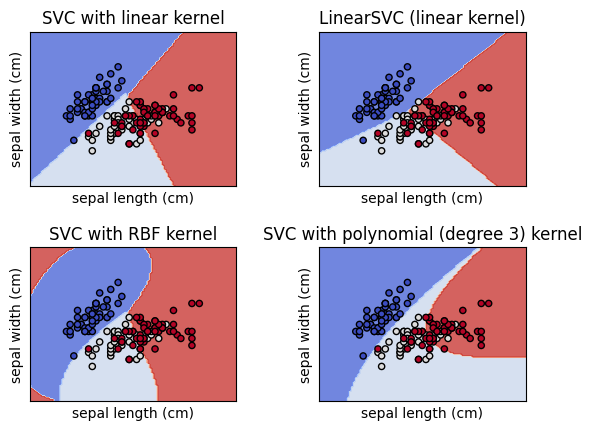

In [2]:
import matplotlib.pyplot as plt

from sklearn import datasets, svm
from sklearn.inspection import DecisionBoundaryDisplay

# import some data to play with
iris = datasets.load_iris()
# Take the first two features. We could avoid this by using a two-dim dataset
X = iris.data[:, :2]
y = iris.target

# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors
C = 1.0  # SVM regularization parameter
models = (
    svm.SVC(kernel="linear", C=C),
    svm.LinearSVC(C=C, max_iter=10000, dual="auto"),
    svm.SVC(kernel="rbf", gamma=0.7, C=C),
    svm.SVC(kernel="poly", degree=3, gamma="auto", C=C),
)
models = (clf.fit(X, y) for clf in models)

# title for the plots
titles = (
    "SVC with linear kernel",
    "LinearSVC (linear kernel)",
    "SVC with RBF kernel",
    "SVC with polynomial (degree 3) kernel",
)

# Set-up 2x2 grid for plotting.
fig, sub = plt.subplots(2, 2)
plt.subplots_adjust(wspace=0.4, hspace=0.4)

X0, X1 = X[:, 0], X[:, 1]

for clf, title, ax in zip(models, titles, sub.flatten()):
    disp = DecisionBoundaryDisplay.from_estimator(
        clf,
        X,
        response_method="predict",
        cmap=plt.cm.coolwarm,
        alpha=0.8,
        ax=ax,
        xlabel=iris.feature_names[0],
        ylabel=iris.feature_names[1],
    )
    ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors="k")
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)

plt.show()

Задание 6 (k-средних)

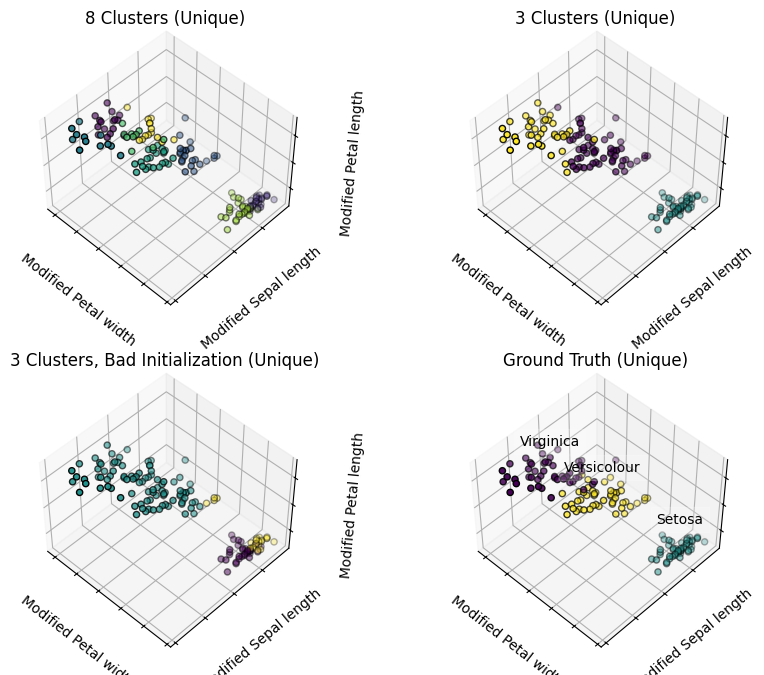

In [22]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn import datasets
from sklearn.cluster import KMeans

np.random.seed(10)

iris = datasets.load_iris()
X = iris.data
y = iris.target

estimators = [
    ("my_k_means_iris_8", KMeans(n_clusters=8, n_init="auto")),
    ("my_k_means_iris_3", KMeans(n_clusters=3, n_init="auto")),
    ("my_k_means_iris_bad_init", KMeans(n_clusters=3, n_init=1, init="random")),
]

fig = plt.figure(figsize=(10, 8))
titles = ["8 Clusters (Unique)", "3 Clusters (Unique)", "3 Clusters, Bad Initialization (Unique)"]
for idx, ((name, est), title) in enumerate(zip(estimators, titles)):
    ax = fig.add_subplot(2, 2, idx + 1, projection="3d", elev=48, azim=134)
    est.fit(X)
    labels = est.labels_

    ax.scatter(X[:, 3], X[:, 0], X[:, 2], c=labels.astype(float), edgecolor="k")

    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.zaxis.set_ticklabels([])
    ax.set_xlabel("Modified Petal width")
    ax.set_ylabel("Modified Sepal length")
    ax.set_zlabel("Modified Petal length")
    ax.set_title(title)

# Plot the ground truth
ax = fig.add_subplot(2, 2, 4, projection="3d", elev=48, azim=134)

for name, label in [("Setosa", 0), ("Versicolour", 1), ("Virginica", 2)]:
    ax.text3D(
        X[y == label, 3].mean(),
        X[y == label, 0].mean(),
        X[y == label, 2].mean() + 2,
        name,
        horizontalalignment="center",
        bbox=dict(alpha=0.2, edgecolor="w", facecolor="w"),
    )
# Reorder the labels to have colors matching the cluster results
y = np.choose(y, [1, 2, 0]).astype(float)
ax.scatter(X[:, 3], X[:, 0], X[:, 2], c=y, edgecolor="k")

ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])
ax.set_xlabel("Modified Petal width")
ax.set_ylabel("Modified Sepal length")
ax.set_zlabel("Modified Petal length")
ax.set_title("Ground Truth (Unique)")

plt.subplots_adjust(wspace=0.25, hspace=0.25)
plt.show()


Задание 7 (Кластеризация методом Уорда)

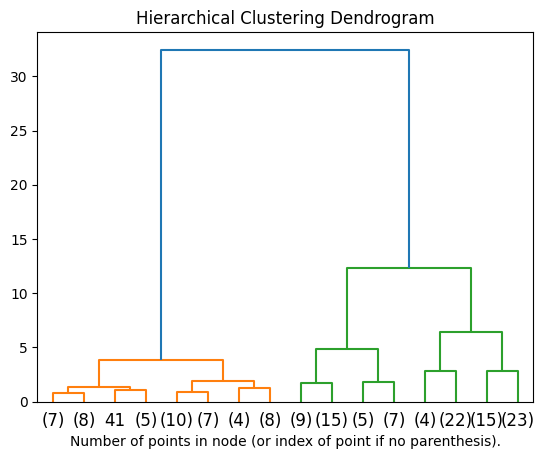

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram

from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets import load_iris


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


iris = load_iris()
X = iris.data

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(X)
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

Задание 8 (Спектральная кластеризация)

c:\Users\galileg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


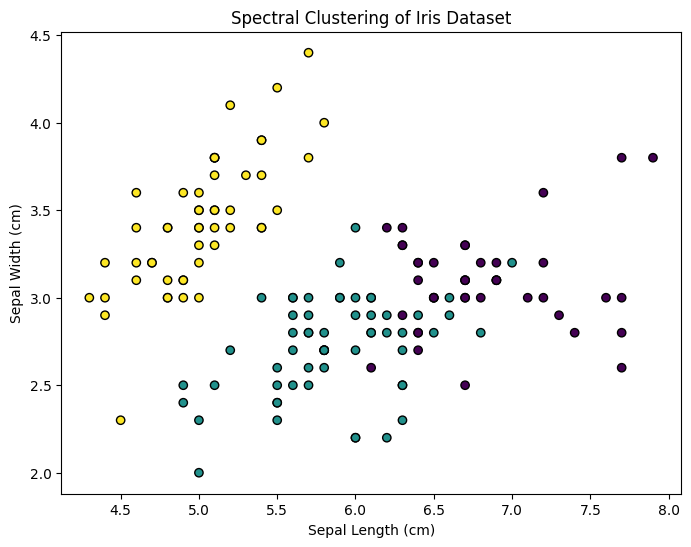

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering
from sklearn import datasets

# Загрузим данные
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Используем спектральную кластеризацию
spectral = SpectralClustering(n_clusters=3, affinity='nearest_neighbors', random_state=42)
labels = spectral.fit_predict(X)

# Визуализируем результаты
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', edgecolors='k')
plt.xlabel('Sepal Length (cm)')
plt.ylabel('Sepal Width (cm)')
plt.title('Spectral Clustering of Iris Dataset')
plt.show()


Задание 9


In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

original_data = pd.read_csv("./HTRU_2.csv")
data = original_data.copy()

cols = [
    "Среднее значение интегрального профиля",
    "Стандартное отклонение интегрированного профиля",
    "Избыточный эксцесс интегрального профиля",
    "Перекос интегрального профиля",
    "Среднее значение кривой DM-SNR",
    "Стандартное отклонение кривой DM-SNR",
    "Избыточный эксцесс кривой DM-SNR",
    "Перекос кривой DM-SNR",
    "Class",
]

data.columns = cols

# удаляем целевую переменную
y_data = data["Class"]
X_data = data.drop("Class", axis=1)

X_data

Среднее значение интегрального профиля  \
0                                  102.507812   
1                                  103.015625   
2                                  136.750000   
3                                   88.726562   
4                                   93.570312   
...                                       ...   
17892                              136.429688   
17893                              122.554688   
17894                              119.335938   
17895                              114.507812   
17896                               57.062500   

       Стандартное отклонение интегрированного профиля  \
0                                            58.882430   
1                                            39.341649   
2                                            57.178449   
3                                            40.672225   
4                                            46.698114   
...                                                ...   
17892                                        59.847421   
17893                                        49.485605   
17894                                        59.935939   
17895                                        53.902400   
17896                                        85.797340   

       Избыточный эксцесс интегрального профиля  \
0                                      0.465318   
1                                      0.323328   
2                                     -0.068415   
3                                      0.600866   
4                                      0.531905   
...                                         ...   
17892                                 -0.187846   
17893                                  0.127978   
17894                                  0.159363   
17895                                  0.201161   
17896                                  1.406391   

       Перекос интегрального профиля  Среднее значение кривой DM-SNR  \
0                          -0.515088                        1.677258   
1                           1.051164                        3.121237   
2                          -0.636238                        3.642977   
3                           1.123492                        1.178930   
4                           0.416721                        1.636288   
...                              ...                             ...   
17892                      -0.738123                        1.296823   
17893                       0.323061                       16.409699   
17894                      -0.743025                       21.430602   
17895                      -0.024789                        1.946488   
17896                       0.089520                      188.306020   

       Стандартное отклонение кривой DM-SNR  Избыточный эксцесс кривой DM-SNR  \
0                                 14.860146                         10.576487   
1                                 21.744669                          7.735822   
2                                 20.959280                          6.896499   
3                                 11.468720                         14.269573   
4                                 14.545074                         10.621748   
...                                     ...                               ...   
17892                             12.166062                         15.450260   
17893                             44.626893                          2.945244   
17894                             58.872000                          2.499517   
17895                             13.381731                         10.007967   
17896                             64.712562                         -1.597527   

       Перекос кривой DM-SNR  
0                 127.393580  
1                  63.171909  
2                  53.593661  
3                 252.567306  
4                 131.394004  
...                      ...  
17892             285.931022  
17893               8.

C:\Users\galileg\AppData\Local\Temp\ipykernel_12136\2100554374.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col], kde=False)


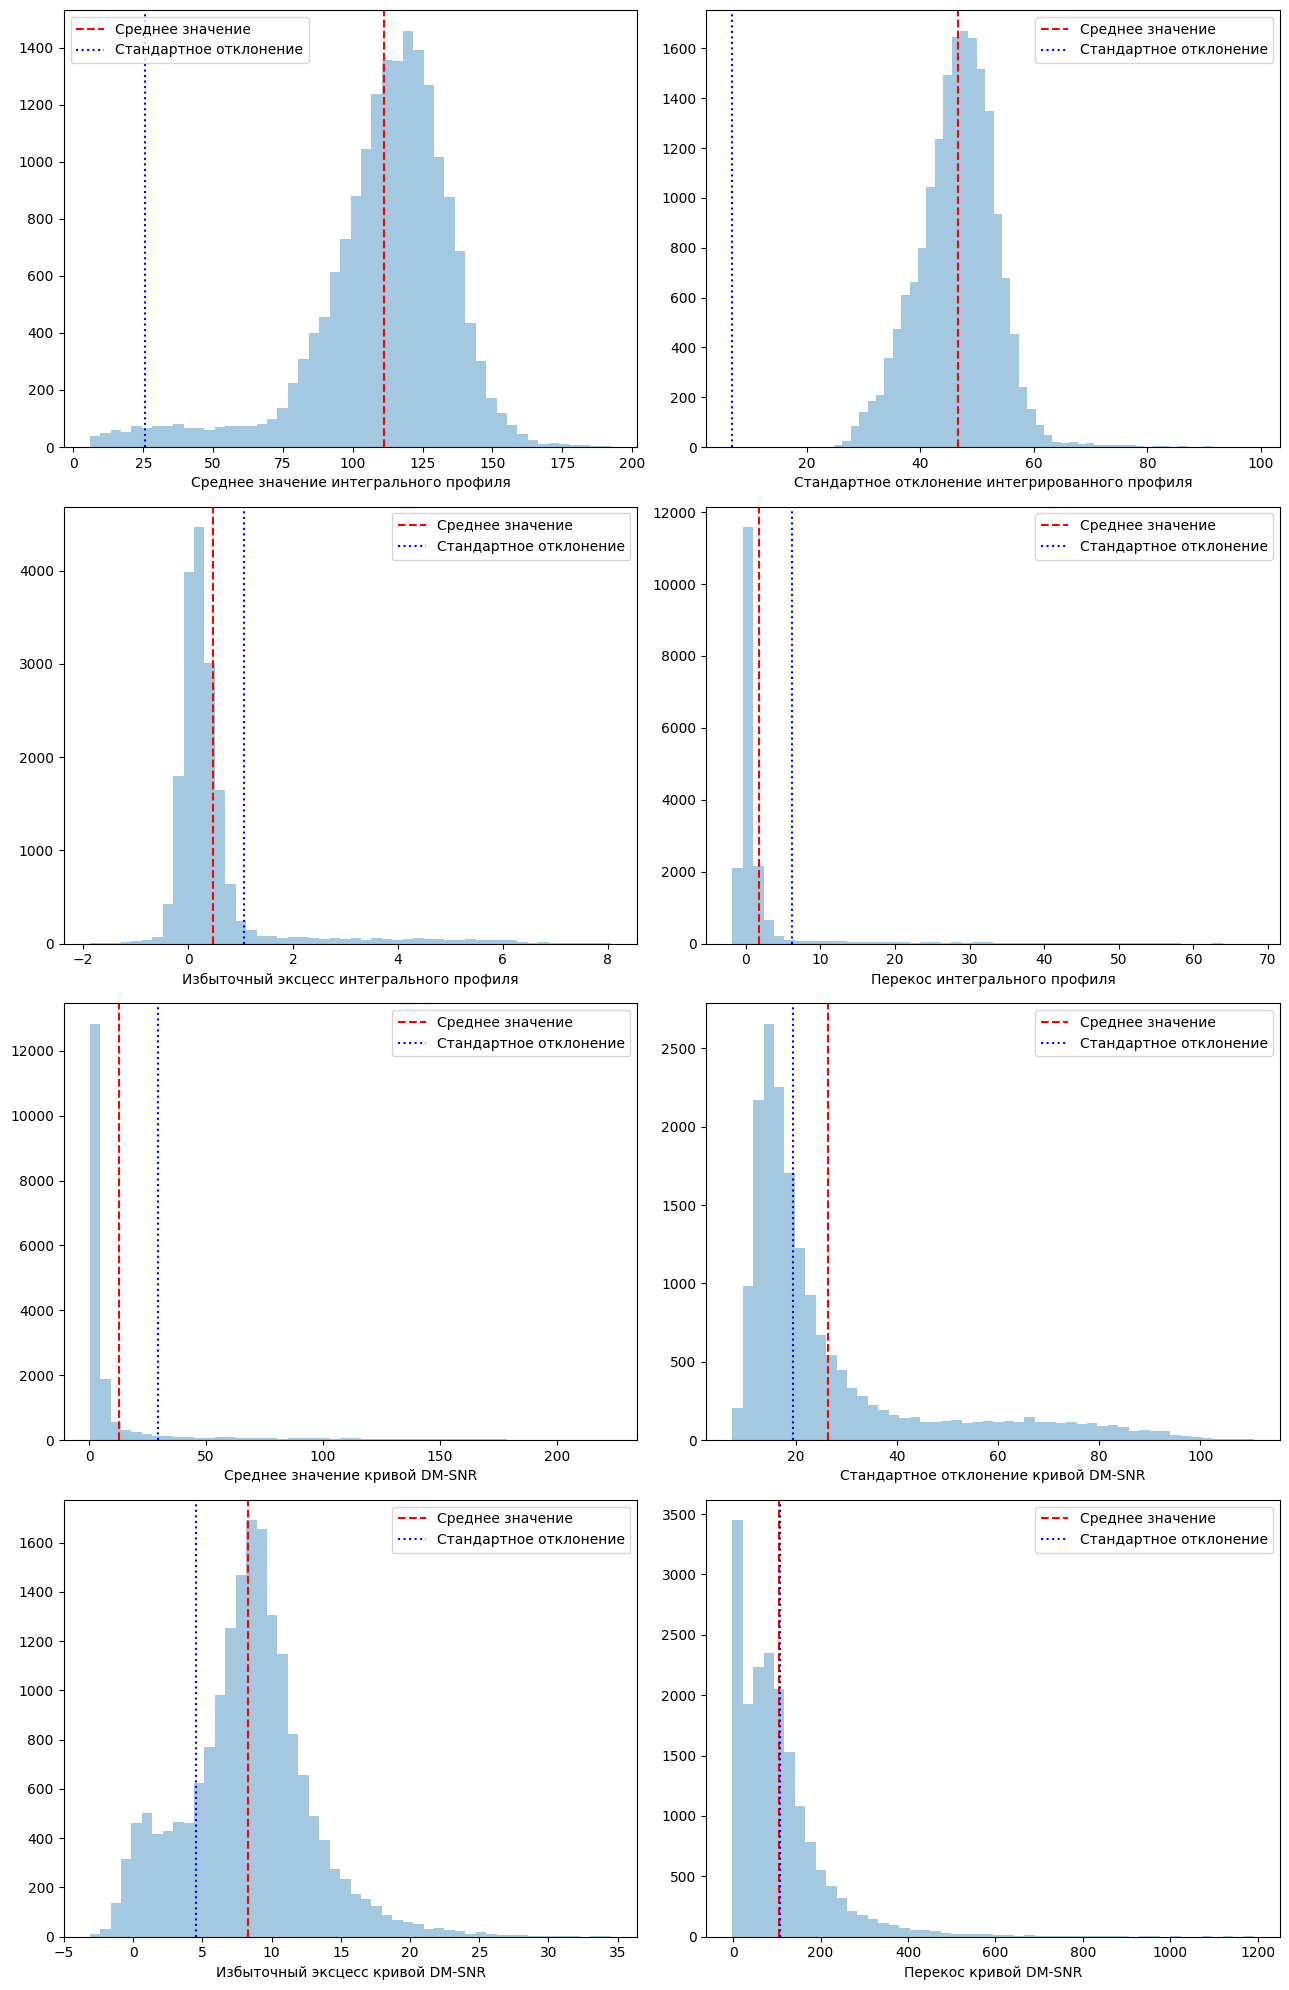

In [35]:
# Создадим DataFrame из данных
df = pd.DataFrame(X_data)


# Визуализируем результаты
plt.figure(figsize=(13, 20))
for i, col in enumerate(df.columns):
    plt.subplot(4, 2, i + 1)
    sns.distplot(df[col], kde=False)
    plt.axvline(df[col].mean(), color="r", linestyle="dashed", label="Среднее значение")
    plt.axvline(df[col].std(), color="b", linestyle="dotted", label="Стандартное отклонение")
    plt.legend(loc="best")

plt.tight_layout()
plt.show()

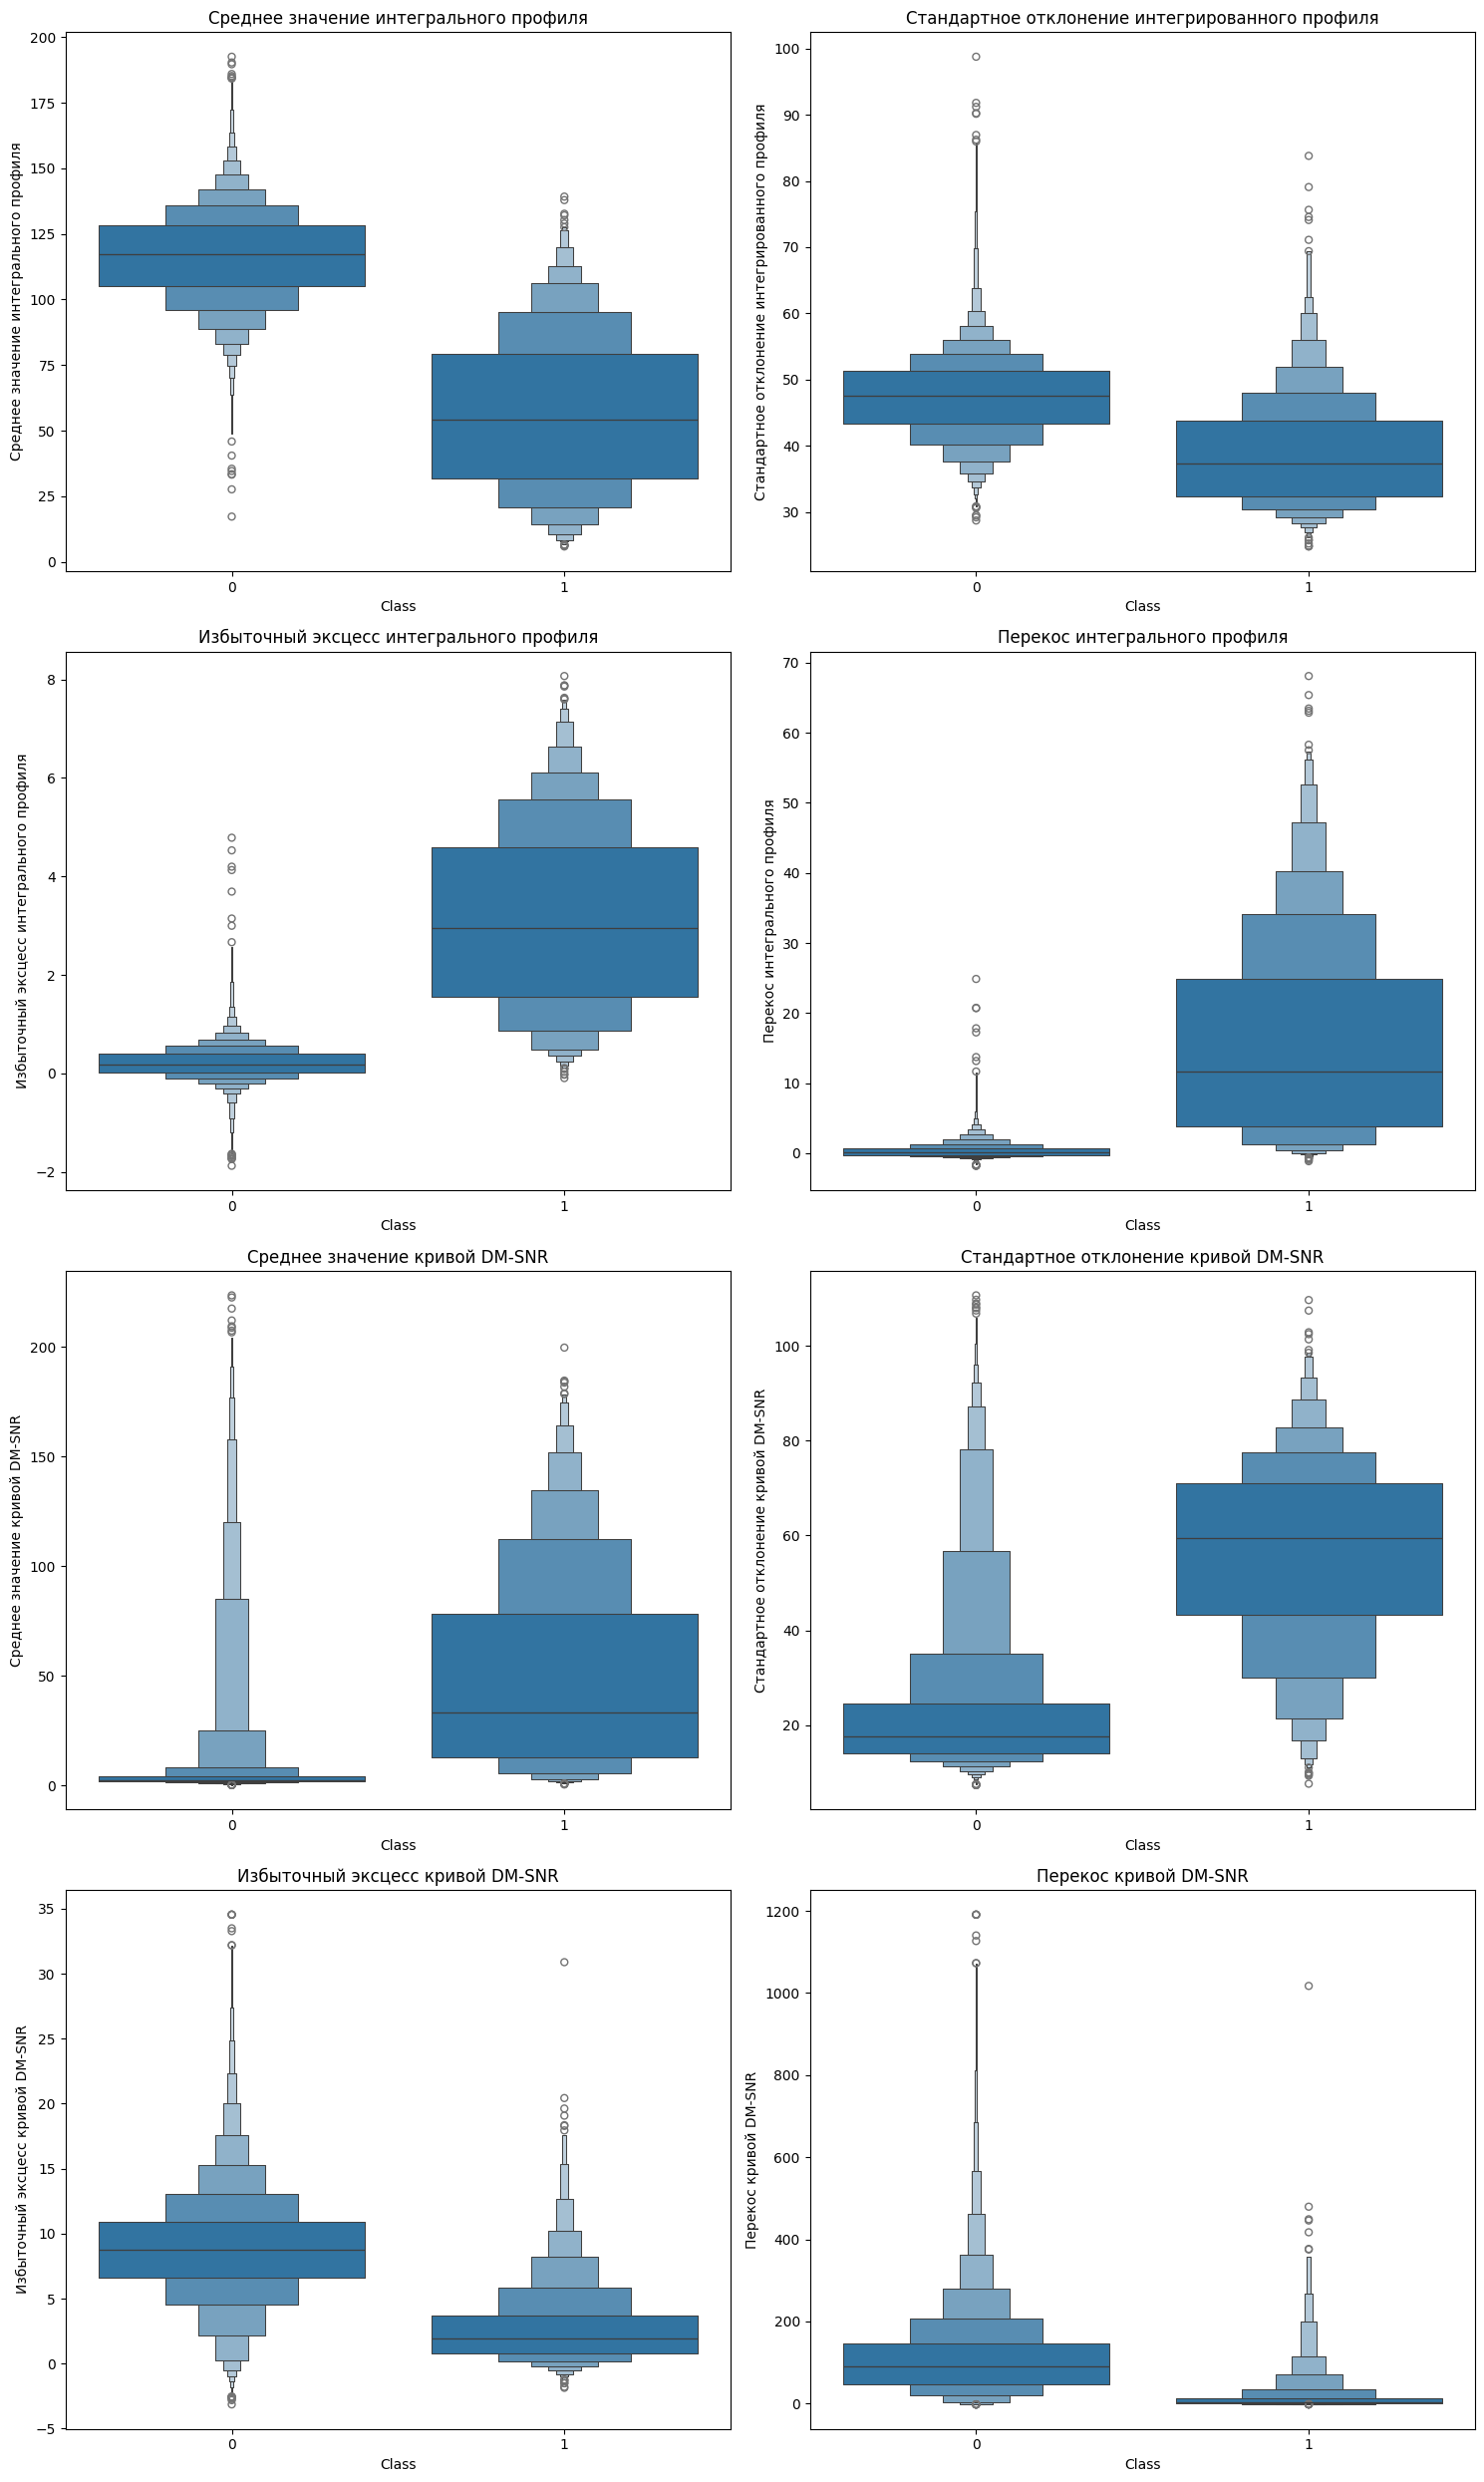

In [39]:
# Создадим DataFrame из данных
# Визуальное представление статистической сводки данных с использованием Boxenplot
plt.figure(figsize=(15, 25))
for i, col in enumerate(X_data.columns):
    plt.subplot(4, 2, i + 1)
    sns.boxenplot(x=y_data, y=X_data[col])
    plt.title(col)

plt.tight_layout()
plt.show()

[0.5161509  0.26843666 0.10158157 0.05721447 0.03206632 0.01999274
 0.00253838 0.00201897]


Text(0.5, 1.0, 'Pulsars Dataset - Explained Variance')

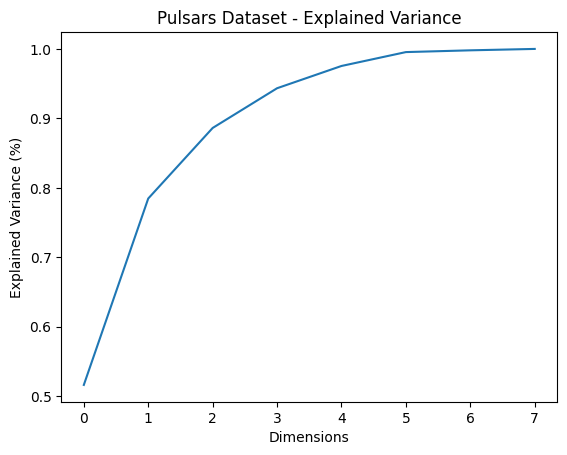

In [40]:
# разделяем набор данных на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(
    X_data, y_data, test_size=0.2, random_state=0
)

# применяем StandardScaler к обучающему набору
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_data.columns)

# преобразуем тестовый набор
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_data.columns)

# применяем PCA к обоим наборам данных
X_for_pca = pd.concat([X_train, X_test], ignore_index=True)

# Principal Component Analysis с использованием 8 измерений (признаков) набора данных
pca = PCA(n_components=8)
X_reduced = pca.fit_transform(X_for_pca)

# We can now retrieve the important information
print(pca.explained_variance_ratio_)

# Построение графика суммирования объясненной дисперсии
plt.figure()
sns.lineplot(data=np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance (%)")
plt.title("Pulsars Dataset - Explained Variance")

In [41]:
# создаём уменьшенный двумерный набор данных
pca = PCA(n_components=2)
X_reduced = pd.DataFrame(
    pca.fit_transform(X_for_pca),
    columns=["Главная компонента 1", "Главная компонента 2"],
)

X_reduced.head()

Главная компонента 1  Главная компонента 2
0             -0.047451             -2.313865
1             -0.275857             -1.019571
2              0.333196             -0.586007
3              6.638670              1.851893
4              0.115171              0.608944

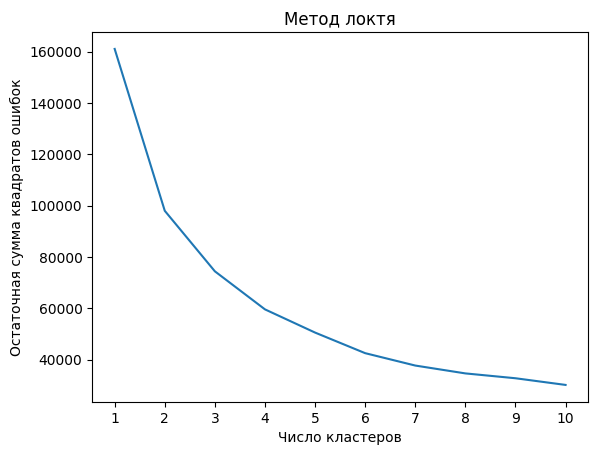

In [42]:
from scipy.io import arff

data = arff.loadarff('HTRU_2.arff')
df = pd.DataFrame(data[0])
df.head()

# отбрасываем строки со значениями NA в любых столбцах
df = df.dropna()

# создаём масштабированный DataFrame, в котором каждая переменная имеет среднее значение 0 и стандартное отклонение 1
scaled_df = StandardScaler().fit_transform(df)

#инициализируем параметры для k-means
kmeans_kwargs = {
"init": "random",
"n_init": 10,
"random_state": 1,
}

# создаём список для хранения значений SSE для каждого k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_df)
    sse.append(kmeans.inertia_)

# визуализация результатов
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Число кластеров")
plt.ylabel("Остаточная сумма квадратов ошибок")
plt.title("Метод локтя")
plt.show()

c:\Users\galileg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Text(0.5, 1.0, 'Кластеризация по методу K-средних с данными, уменьшенными с помощью PCA')

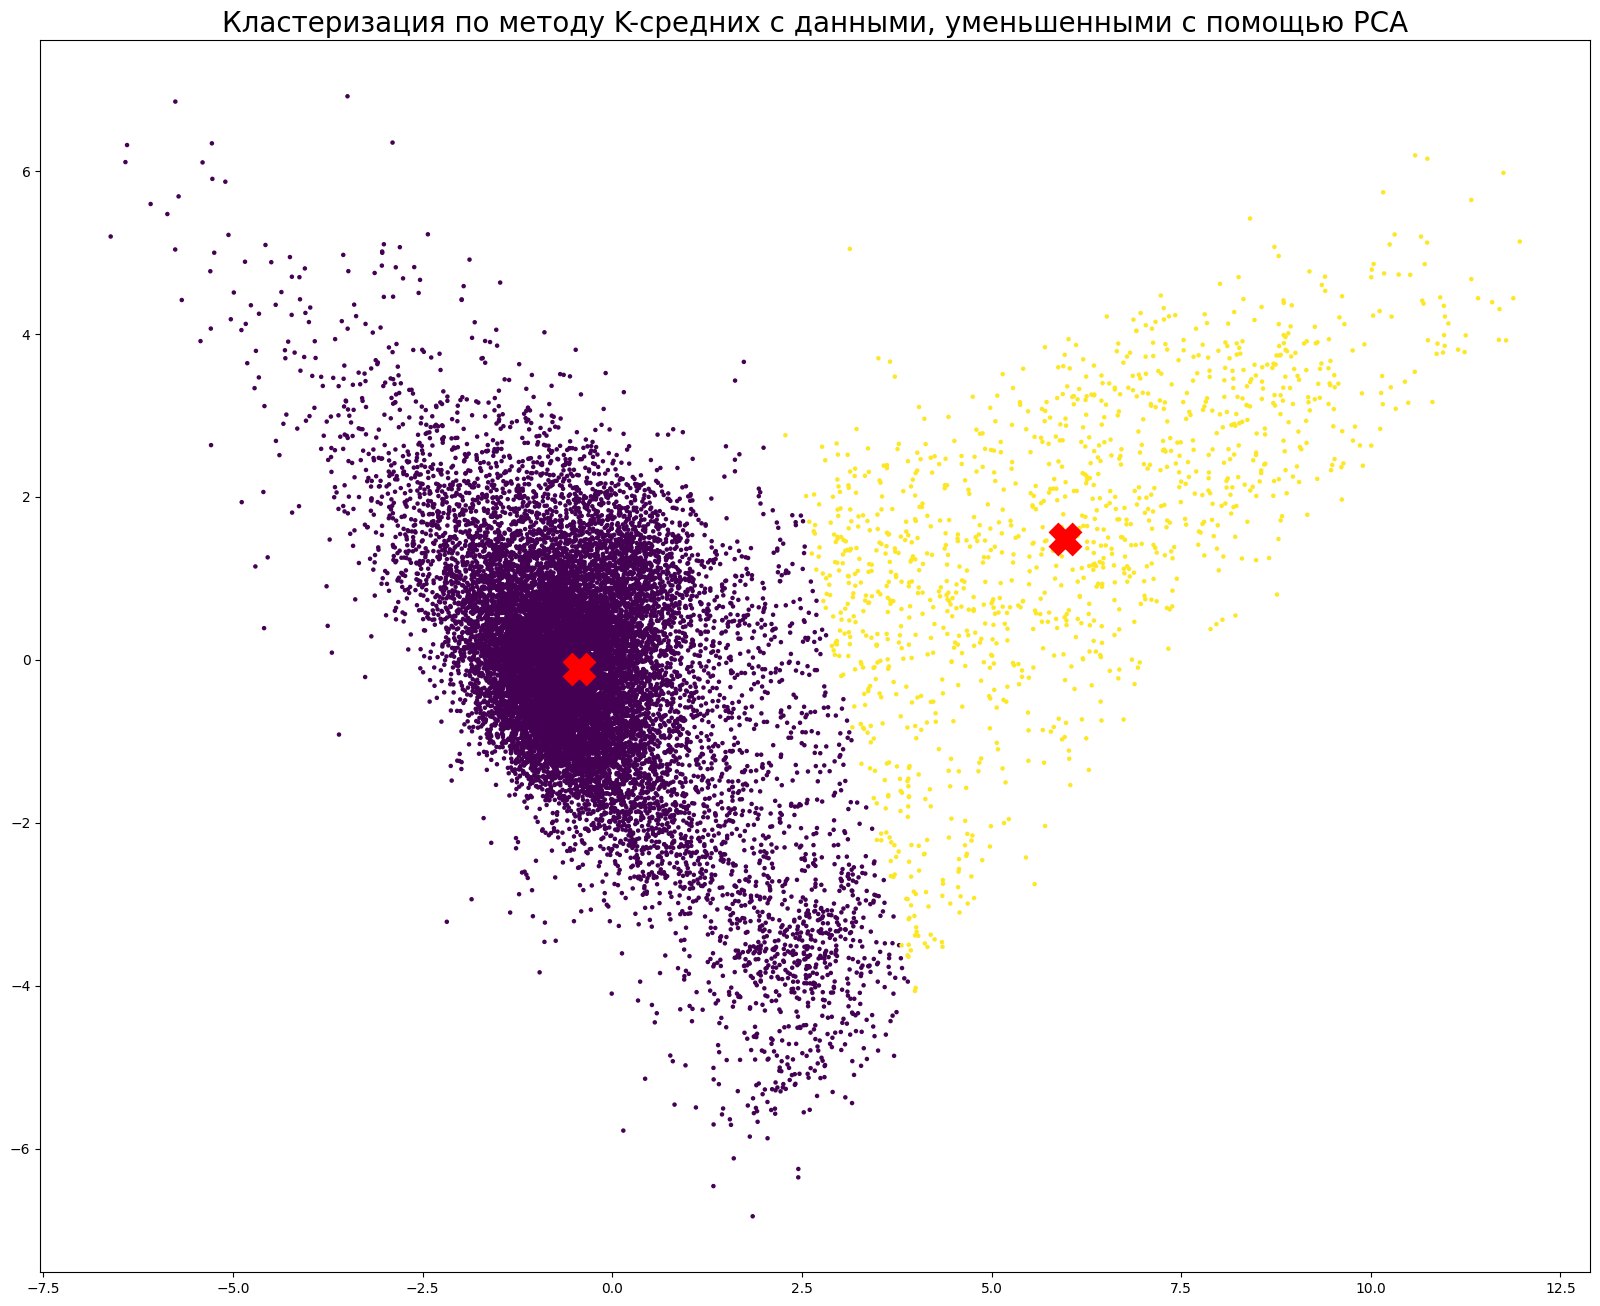

In [43]:
# создаём уменьшенный двумерный набор данных
pca = PCA(n_components=2)
X_reduced = pd.DataFrame(
    pca.fit_transform(X_for_pca),
    columns=["Главная компонента 1", "Главная компонента 2"],
)

# используем алгоритм SKLearn на наборе данных
kmeans = KMeans(n_clusters=2)
kmeans.fit(X_reduced)
clusters = kmeans.predict(X_reduced)

# определяем центры кластеров
centers_pulsars = kmeans.cluster_centers_

def plot_clusters(X, clusters=None, centers=None):
    # добавляем точки на график
    plt.scatter(X[:, 0], X[:, 1], c=clusters, s=5, cmap="viridis")

    # Plot the centers if they are identified
    if np.any(centers):
        plt.scatter(
            centers[:, 0], centers[:, 1], marker="x", s=300, linewidths=10, color="r"
        )


# преобразование в массив NumPy для построения графиков
X_plot = np.array(X_reduced)

# изображение результатов кластеризации k-means
plt.figure(figsize=[20, 16])
plot_clusters(X_plot, clusters=clusters, centers=centers_pulsars)
plt.title("Кластеризация по методу K-средних с данными, уменьшенными с помощью PCA", fontsize=20)